In [1]:
import numpy as np
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinHalfFermionSite
from tenpy.models.lattice import Square
from tenpy.algorithms import dmrg
from tenpy.models.model import CouplingModel, CouplingMPOModel

import pickle, time
import matplotlib.pyplot as plt

In [2]:

# Define the lattice parameters
Lx, Ly = 4, 4  # dimensions of the lattice

# Create the SpinHalfFermionSite
site = SpinHalfFermionSite() 

# Create the square lattice with the SpinHalfFermionSite
lattice = Square(Lx, Ly, site, bc=['open', 'periodic'])


lattice.boundary_conditions

['open', 'periodic']

In [6]:


class CustomFermiHubbardModel(CouplingMPOModel):
    def __init__(self, params):
        self.tx = params.pop('tx', 1.0)
        self.ty = params.pop('ty', 1.0)
        self.U = params.pop('U', 1.0)
        self.mu = params.pop('mu', 0.0)
        super().__init__(params)

    def init_terms(self, params):
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            if dx[0] != 0:  # Hopping in the x-direction
                self.add_coupling(-self.tx, u1, 'Cdu', u2, 'Cu', dx, plus_hc=True)
                self.add_coupling(-self.tx, u1, 'Cdd', u2, 'Cd', dx, plus_hc=True)
            if dx[1] != 0:  # Hopping in the y-direction
                self.add_coupling(-self.ty, u1, 'Cdu', u2, 'Cu', dx, plus_hc=True)
                self.add_coupling(-self.ty, u1, 'Cdd', u2, 'Cd', dx, plus_hc=True)
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(self.U, u, 'NuNd')
            self.add_onsite(self.mu, u, 'Ntot')

# Define the model parameters
model_params = {
    'lattice': lattice,
    'tx': -1.0,  # Hopping amplitude in the x-direction
    'ty': -0.5,  # Hopping amplitude in the y-direction
    'U': 4.0,    # On-site interaction strength
    'mu': 0.0,   # Chemical potential
}

# Create the custom Fermi-Hubbard model
model = CustomFermiHubbardModel(model_params)

# Print the model to verify
print(model)


In [8]:


def run_dmrg_2d(Lx, Ly, U, tx, ty, mu, chi_max, sweeps, charge=0):
    # Define the lattice and SpinHalfFermionSite without any conservation law for simplicity
    site = SpinHalfFermionSite()
    lattice = Square(Lx, Ly, site, bc=['open', 'periodic'], order='default')

    # Set up the model parameters
    model_params = {
        'lattice': lattice,
        'tx': tx,  # Hopping amplitude in the x-direction
        'ty': ty,  # Hopping amplitude in the y-direction
        'U': U,
        'mu': mu
    }

    model = CustomFermiHubbardModel(model_params)

    # Initialize with an alternating pattern of filled and empty sites appropriate for 2D
    initial_state = []
    for x in range(Lx):
        for y in range(Ly):
            if (x + y) % 2 == 0:
                initial_state.append('up')
            else:
                initial_state.append('down')

    # Depending on charge modify the last site
    if charge == 1:
        initial_state[-1] = 'full'
    elif charge == -1:
        initial_state[-1] = 'empty'

    psi = MPS.from_product_state(model.lat.mps_sites(), initial_state, bc='finite')

    dmrg_params = {
        'mixer': True,
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-7
        },
        'max_sweeps': sweeps,
    }

    eng = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)
    E0, psi = eng.run()
    return E0

# Example usage
Lx, Ly = 2, 2
U = 4
tx = 1.0
ty = 1.0
mu = 0.0
chi_max = 2000
sweeps = 60
charge = 0

st_time = time.time()

ground_state_energy = run_dmrg_2d(Lx, Ly, U, tx, ty, mu, chi_max, sweeps, charge)/(Ly*Lx)

print(str(time.time()-st_time))
print("Ground state energy:", ground_state_energy)


0.6183679103851318
Ground state energy: -1.2504298553379927


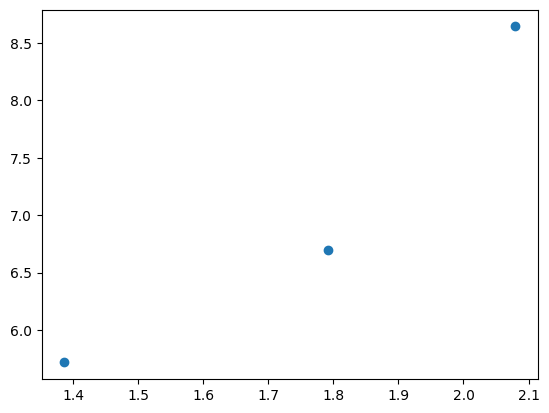

In [4]:
#Time scaling for Ly = 4
L_vals = np.array([4, 6, 8])
time_scaling = np.array([303.77138781547546, 809.2236495018005, 5669.86])

plt.scatter(np.log(L_vals), np.log(time_scaling))

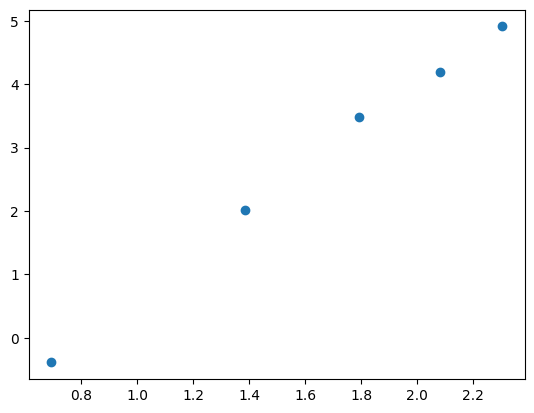

In [6]:
L_vals = np.array([2, 4, 6, 8, 10])
time_scaling = np.array([0.6764464378356934, 7.467154026031494, 32.66263818740845, 66.7620837688446, 135.9267439842224])


plt.scatter(np.log(L_vals), np.log(time_scaling))


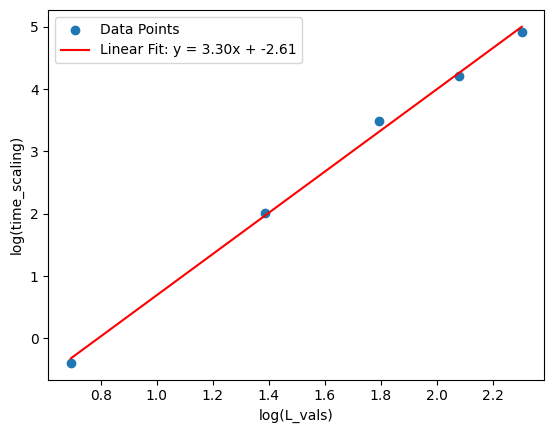

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Log-transform the data
log_L_vals = np.log(L_vals)
log_time_scaling = np.log(time_scaling)

# Perform a linear fit on the log-transformed data
coefficients = np.polyfit(log_L_vals, log_time_scaling, 1)
slope, intercept = coefficients

# Generate fitted values
fitted_values = np.polyval(coefficients, log_L_vals)

# Plot the data points and the linear fit
plt.scatter(log_L_vals, log_time_scaling, label='Data Points')
plt.plot(log_L_vals, fitted_values, color='red', label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('log(L_vals)')
plt.ylabel('log(time_scaling)')
plt.legend()
plt.show()


In [22]:
U = 6.0  
t = 1.0
mu = 0  # Chemical potential (often set to 0 for simplicity at half filling)
chi_max = 2000  # Maximum bond dimension
sweeps = 40  # Number of DMRG sweeps
k_num = 10

Lx_list = [2]
Ly_list = [2]
GS_list = np.zeros(shape=(len(Lx_list), len(Ly_list)))

time_list = np.zeros(shape=(len(Lx_list), len(Ly_list)))
for i, Lx in enumerate(Lx_list):
    for j, Ly in enumerate(Ly_list):
        print(Lx, Ly)
        st_time_ind = time.time()
        energy_arr = np.zeros(k_num)
        for ky in range(-int(k_num/2), int(k_num/2)):
            ty = t*np.exp(1j*ky/k_num*np.pi/Ly)
            tx = t
            ground_state_energy = run_dmrg_2d(Lx, Ly, U, tx, ty, mu, chi_max, sweeps)/Ly
            energy_arr[ky+int(k_num/2)] = ground_state_energy
        GS_list[i,j] = energy_arr.mean()/Lx
        time_list[i,j] = time.time() - st_time_ind
        print(time_list[i,j])

print(GS_list)

2 2
3.7624311447143555
[[-0.87413816]]


In [ ]:
GS_list